In [12]:
# 필요한 라이브러리 불러오기
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip

# 시각화 관련 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

# 데이터 준비 및 모델 평가 관련 라이브러리
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

# 텐서플로 및 케라스 관련 라이브러리
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from keras.layers import BatchNormalization, Input, Lambda
from keras import regularizers
from keras.losses import mse, binary_crossentropy

In [13]:
# Define the path to your CSV file
file_path = "C:/Users/wdd45/OneDrive/바탕 화면/딥러닝응용/\creditcard.csv"

data = pd.read_csv(file_path)


In [14]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [15]:
dataX = data.copy().drop(['Class','Time'],axis=1)
dataY = data['Class'].copy()


In [16]:
dataX

dataY

0         0
1         0
2         0
3         0
4         0
         ..
284802    0
284803    0
284804    0
284805    0
284806    0
Name: Class, Length: 284807, dtype: int64

In [17]:
# 노이즈 추가
noise_factor = 0.2
dataX_noisy = dataX + noise_factor * np.random.normal(loc=0, scale=1, size=dataX.shape)


In [18]:
# 데이터 표준화
featuresToScale = dataX.columns
sX = pp.StandardScaler(copy=True, with_mean=True, with_std=True)
dataX_noisy.loc[:,featuresToScale] = sX.fit_transform(dataX_noisy[featuresToScale])


In [19]:
X_train, X_test, y_train, y_test = train_test_split(dataX_noisy, dataY, test_size=0.33, random_state=2018, stratify=dataY)


In [20]:
# 모델 구성 (중간 은닉층 차원 확장)
model = Sequential()
model.add(Dense(units=100, activation='linear', input_dim=29))
model.add(Dense(units=29, activation='linear'))


In [21]:
# 모델 컴파일 및 훈련
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
num_epochs = 10
batch_size = 32
history = model.fit(x=X_train, y=X_train, epochs=num_epochs, batch_size=batch_size, shuffle=True, validation_data=(X_test, X_test), verbose=1)


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
5959/5964 [============================>.] - ETA: 0s - loss: 0.0146 - accuracy: 0.9725WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000002BD9BB43DC8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=1

In [22]:
# 이상 감지 함수 정의
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF) - np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss, index=originalDF.index)
    loss = (loss - np.min(loss)) / (np.max(loss) - np.min(loss))
    return loss

In [23]:
# 테스트 데이터에 대한 예측 및 평가
predictions = model.predict(X_test, verbose=1)
anomalyScoresAE = anomalyScores(X_test, predictions)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2938/2938 [==============================] - 3s 1ms/step


In [27]:
def plotResults(trueLabels, anomalyScores, returnPreds=False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = precision_recall_curve(preds['trueLabel'], preds['anomalyScore'])
    average_precision = average_precision_score(preds['trueLabel'], preds['anomalyScore'])

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(recall, precision, 'b', label='Precision-Recall curve')
    plt.fill_between(recall, precision, alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    
    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], preds['anomalyScore'])
    roc_auc = auc(fpr, tpr)

    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.fill_between(fpr, tpr, alpha=0.2, color='b')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    
    plt.show()
    
    if returnPreds == True:
        return preds, average_precision

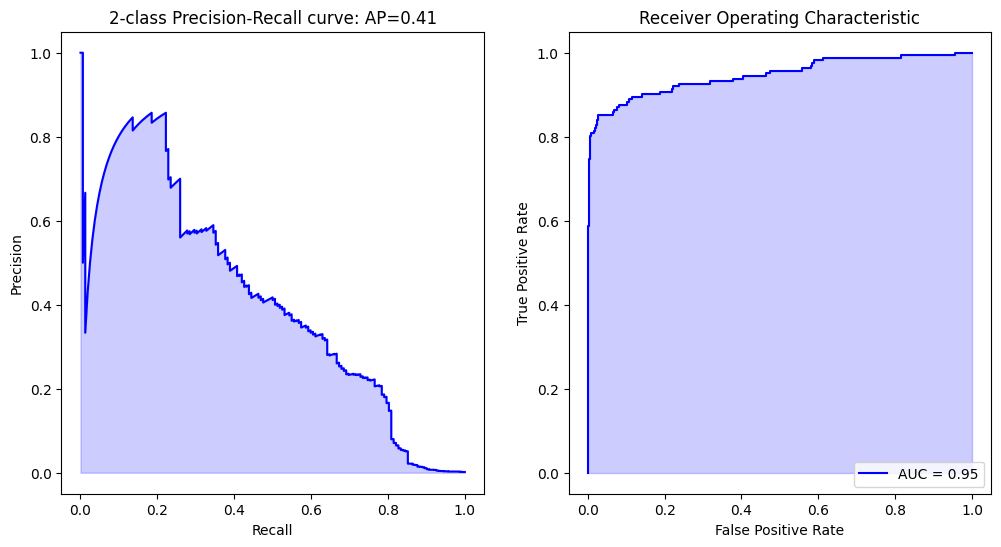

In [28]:
preds = plotResults(y_test, anomalyScoresAE, True)
model.reset_states()

In [29]:
# # 테스트 데이터에 대한 예측 및 평가
# predictions = model.predict(X_test, verbose=1)
# anomalyScoresAE = anomalyScores(X_test, predictions)
# preds = plotResults(y_test, anomalyScoresAE, True)
# model.reset_states()